In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.optimize import minimize
from scipy.optimize import LinearConstraint


In [8]:
# Import daily prices of the S&P 50 and filter the data to include only the 2019-2024 period
prices = pd.read_excel('SP500 for Code.xlsx', sheet_name='SP50 2015', index_col=0, parse_dates=True)
prices = prices.loc['2019-12-31':'2024-10-15']

# Calculate the daily returns of the S&P 50
returns = prices.pct_change().dropna()
returns = returns[returns.sum(axis=1) != 0]

returns.head()

,APPLE,NVIDIA,MICROSOFT,AMAZON.COM,META PLATFORMS A,ALPHABET 'A',ELI LILLY,BROADCOM,TESLA,WALMART,...,CATERPILLAR,DANAHER,S&P GLOBAL,SERVICENOW,TEXAS INSTRUMENTS,PHILIP MORRIS INTL.,WALT DISNEY,QUALCOMM,MORGAN STANLEY,PFIZER
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.022816,0.019584,0.018516,0.027151,0.022071,0.021868,0.005935,0.020157,0.028517,0.000843,...,0.019298,0.010620,0.017543,0.031595,0.009977,0.001175,0.024684,0.005214,0.017997,-0.001020
2020-01-03,-0.009722,-0.016006,-0.012452,-0.012139,-0.005291,-0.005231,-0.003328,-0.025435,0.029633,-0.008828,...,-0.013884,-0.006190,-0.003348,-0.000480,-0.013275,-0.001878,-0.011471,-0.018830,-0.016141,-0.005363
2020-01-06,0.007968,0.004202,0.002585,0.014886,0.018834,0.026654,0.003719,-0.001496,0.019256,-0.002036,...,-0.000674,0.002985,0.007692,0.006080,-0.006961,0.011643,-0.005802,-0.005861,-0.003516,-0.001284
2020-01-07,-0.004703,0.012098,-0.009118,0.002092,0.002164,-0.001932,0.001890,-0.003443,0.038797,-0.009266,...,-0.013213,0.009831,0.006952,0.000136,0.019297,0.004418,0.000343,0.028436,-0.001960,-0.003345
2020-01-08,0.016086,0.001884,0.015928,-0.007809,0.010138,0.007118,0.009056,-0.012474,0.049206,-0.003431,...,0.008881,0.001025,0.014343,0.009354,0.002705,0.018981,-0.002059,-0.002922,0.012765,0.008001


In [9]:
monthly_returns = prices.resample('M').last().pct_change().dropna()

/var/folders/dj/3wx6qp3d3v31b81648wbyc5w0000gp/T/ipykernel_8120/3749952209.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = prices.resample('M').last().pct_change().dropna()


In [10]:
# Input parameters
n = prices.shape[1] # number of assets

mu = returns.mean().values * 252 # annualized expected returns

vol = returns.std().values * np.sqrt(252) # annualized volatilities

correl_matrix = returns.corr().values # correlation matrix

x0 = np.ones(n) / n # initial weights

covmat = vol.reshape(1,-1) * correl_matrix * vol.reshape(-1,1) # covariance matrix

In [11]:
# Define the quadratic programming objective function
def QP(x, sigma, mu, gamma):
    return 0.5 * x.T @ sigma @ x - gamma * x.T @ mu

weight_sum_constraint = LinearConstraint(np.ones(x0.shape), lb=1, ub=1)

bounds_noshort = [(0, 1) for _ in range(n)]  # No short-selling, all weights between 0 and 1

# Efficient frontier function
# On pourra réutiliser cette fonction en y ajoutant les constraints et les bounds de notre choix.
def efficient_frontier(gam, covmat, constraint, mu, bounds):

    # Minimization with the defined constraint and bounds
    res = minimize(QP, x0, args=(covmat, mu, gam), 
                   bounds=bounds, constraints=constraint, 
                   options={'disp': False})
    
    optimized_weights = res.x
    mu_optimized = optimized_weights @ mu
    vol_optimized = np.sqrt(optimized_weights @ covmat @ optimized_weights)
    
    return mu_optimized, vol_optimized, optimized_weights

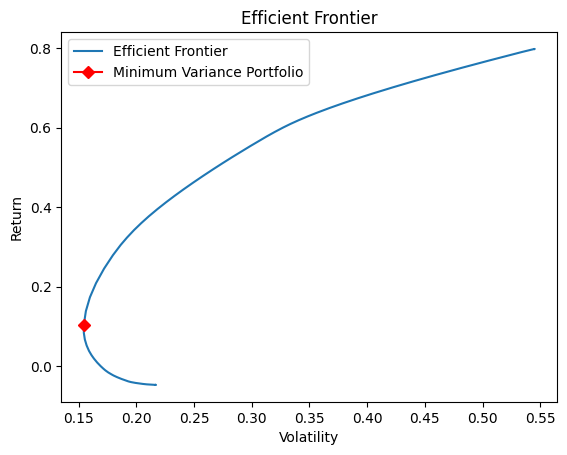

In [12]:
mu_efficient_frontier = []
vol_efficient_frontier = []
weights_efficient_frontier = []

# Define a range of gamma values
gammas = np.linspace(-2, 2, 500)

for gam in gammas:
    mu_optimized, vol_optimized, optimized_weights = efficient_frontier(gam, covmat, weight_sum_constraint, mu, bounds_noshort)
    mu_efficient_frontier.append(mu_optimized)
    vol_efficient_frontier.append(vol_optimized)
    weights_efficient_frontier.append(optimized_weights)

# Index of the gamma = 0 (minimum variance portfolio)
gamma_zero_index = np.argmin(np.abs(gammas))


# Plot efficient frontier
plt.plot(vol_efficient_frontier, mu_efficient_frontier, label='Efficient Frontier')
plt.plot(vol_efficient_frontier[gamma_zero_index], mu_efficient_frontier[gamma_zero_index], color='r', marker='D', label='Minimum Variance Portfolio')
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()
plt.show()

In [13]:
class EfficientFrontier:
    '''
    This class implements the Markowitz Efficient Frontier.
    '''
    def __init__(self, prices, risk_free_rate=None):
        '''
        Initialize the EfficientFrontier object.
        Compute the expected returns, volatilities, correlation matrix and covariance matrix.
        '''
        self.prices = prices  # DataFrame with historical prices
        self.risk_free_rate = risk_free_rate  # Risk-free rate
        self.returns = prices.pct_change().dropna()  # Compute returns
        self.returns = self.returns[self.returns.sum(axis=1) != 0]  # Remove days with zero returns

        # Compute returns and covariances for the risky assets
        self.mu = self.returns.mean().values * 252  # Annualized expected returns
        self.vol = self.returns.std().values * np.sqrt(252)  # Annualized volatilities
        self.correl_matrix = self.returns.corr().values  # Correlation matrix
        self.covmat = self.vol.reshape(1, -1) * self.correl_matrix * self.vol.reshape(-1, 1)  # Covariance matrix
        self.n = self.mu.shape[0]
        self.x0 = np.ones(self.n) / self.n

        # If a risk-free rate is provided, modify the mu, vol, and covmat
        if risk_free_rate is not None:
            self.mu_mod = np.append(self.mu, self.risk_free_rate)  # Append risk-free rate to the expected returns
            self.vol_mod = np.append(self.vol, 0)
            self.covmat_mod = np.zeros((self.n+1, self.n+1))
            self.covmat_mod[:self.n, :self.n] = self.covmat
            self.x0_mod = np.ones(self.n+1) / (self.n+1)
        else:
            self.mu_mod = None
            self.vol_mod = None
            self.covmat_mod = None
            self.x0_mod = None


    def QP(self, x, sigma, mu, gamma):
        '''
        Standard QP problem function.
        Maximize utility by minimizing variance for a given return target (gamma).
        '''
        return 0.5 * x.T @ sigma @ x - gamma * x.T @ mu

    def efficient_frontier(self, n, x0, covmat, mu, gam, short=False):
        '''
        Compute the efficient frontier for a given gamma.
        We need to give the constraints and bounds to the optimizer.
        '''
        constraints = LinearConstraint(np.ones(n), lb=1, ub=1)  # Adjust constraints
        if short:
            bounds = [(None, None) for _ in range(n)]  # Short-selling allowed
        else:
            bounds = [(0, 1) for _ in range(n)]  # No short-selling allowed

        res = minimize(self.QP, x0, args=(covmat, mu, gam),
                    bounds=bounds, constraints=constraints)

        optimized_weights = res.x
        mu_optimized = optimized_weights @ mu
        vol_optimized = np.sqrt(optimized_weights @ covmat @ optimized_weights)

        return mu_optimized, vol_optimized, optimized_weights


    def plot_efficient_frontier(self):
        '''
        Plot the efficient frontier.
        '''
        gammas = np.linspace(-5, 5, 500)  # Range of gamma values for the efficient frontier

        # Compute efficient frontier for risky assets
        frontier1 = [self.efficient_frontier(self.n, self.x0, self.covmat, self.mu, g) for g in gammas]

        # Plot for risky assets only
        gamma_zero_index = np.argmin(np.abs(gammas))
        plt.plot([f[1] for f in frontier1], [f[0] for f in frontier1], '-', label="Efficient Frontier")
        plt.plot(frontier1[gamma_zero_index][1], frontier1[gamma_zero_index][0], color='r', marker='D', label='Minimum Variance Portfolio')

        # If risk-free rate is provided, compute and plot the extended frontier
        if self.risk_free_rate is not None:
            gammas2 = np.linspace(0, self.risk_free_rate*2, 100)
            frontier2 = [self.efficient_frontier(self.n + 1, self.x0_mod, self.covmat_mod, self.mu_mod, g, short=True) for g in gammas2]
            plt.plot([f[1] for f in frontier2], [f[0] for f in frontier2], '--', label="Capital Market Line")

        plt.title('Efficient Frontier')
        plt.xlabel('Volatility')
        plt.ylabel('Return')
        plt.legend()
        plt.show()


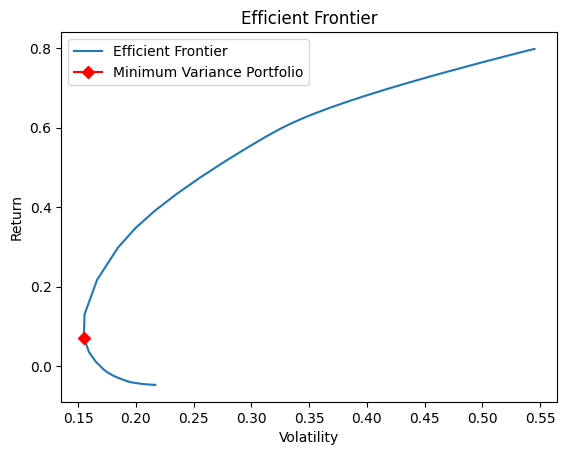

In [14]:
ef = EfficientFrontier(prices, risk_free_rate=None)
ef.plot_efficient_frontier()

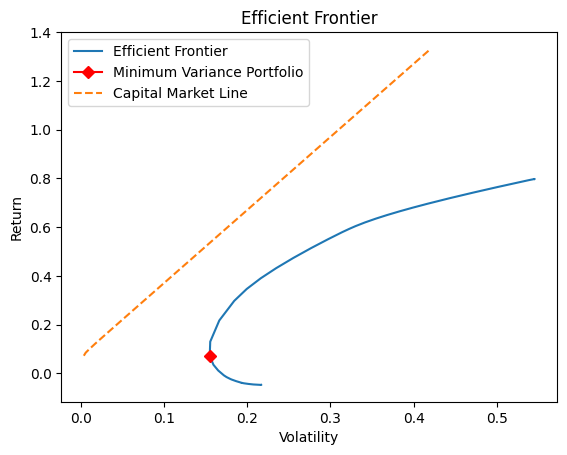

In [15]:
## à débugger: le CML ne devrait pas suivre la forme de l'Efficient Frontier
ef = EfficientFrontier(prices, risk_free_rate=0.07)
ef.plot_efficient_frontier()

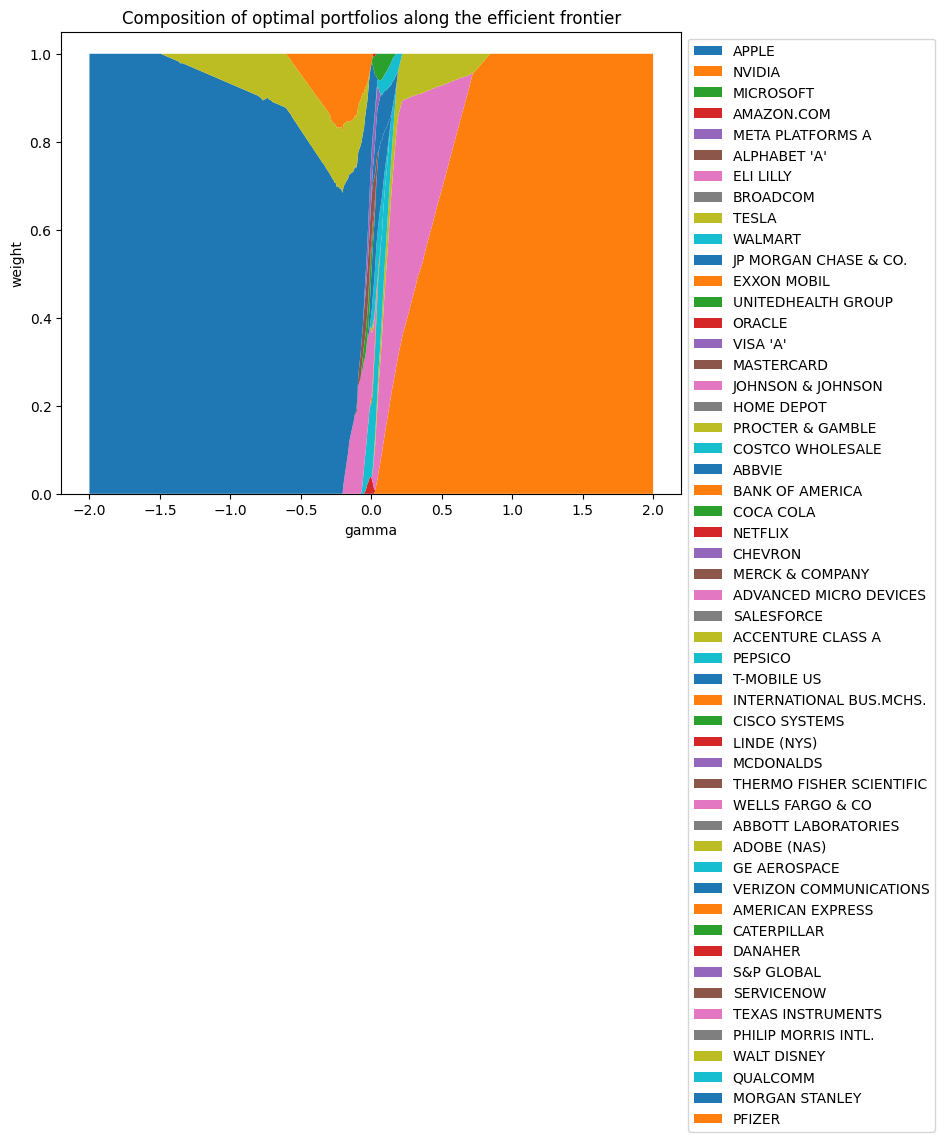

In [16]:
# resampling

data_composition_map = pd.DataFrame(weights_efficient_frontier, columns=prices.columns, index=np.linspace(-2, 2, 500))

fig, ax = plt.subplots(figsize=(8, 6))
ax.stackplot(data_composition_map.index, data_composition_map.T.values, labels=data_composition_map.columns)
ax.set_title('Composition of optimal portfolios along the efficient frontier')
ax.set_ylabel('weight')
ax.set_xlabel('gamma')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [17]:
all_weights = pd.DataFrame(columns = prices.columns)

for i in range(50):
    simulated_r = np.random.multivariate_normal(mu, covmat, 100)
    simulated_mu = np.mean(simulated_r, axis = 0)
    simulated_cov_mat = np.cov(simulated_r, rowvar = False)
    
    weights_efficient_frontier = []
    
    for gam in np.linspace(-0.5,1.5,101):
        weights_efficient_frontier.append(efficient_frontier(gam, simulated_cov_mat, weight_sum_constraint, simulated_mu, bounds_noshort)[2])
        
    to_append = pd.DataFrame(weights_efficient_frontier, columns = prices.columns)
    to_append['gamma'] = np.linspace(-0.5,1.5,101)

    all_weights = pd.concat([all_weights, to_append], ignore_index = True)

/var/folders/dj/3wx6qp3d3v31b81648wbyc5w0000gp/T/ipykernel_8120/244841154.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_weights = pd.concat([all_weights, to_append], ignore_index = True)


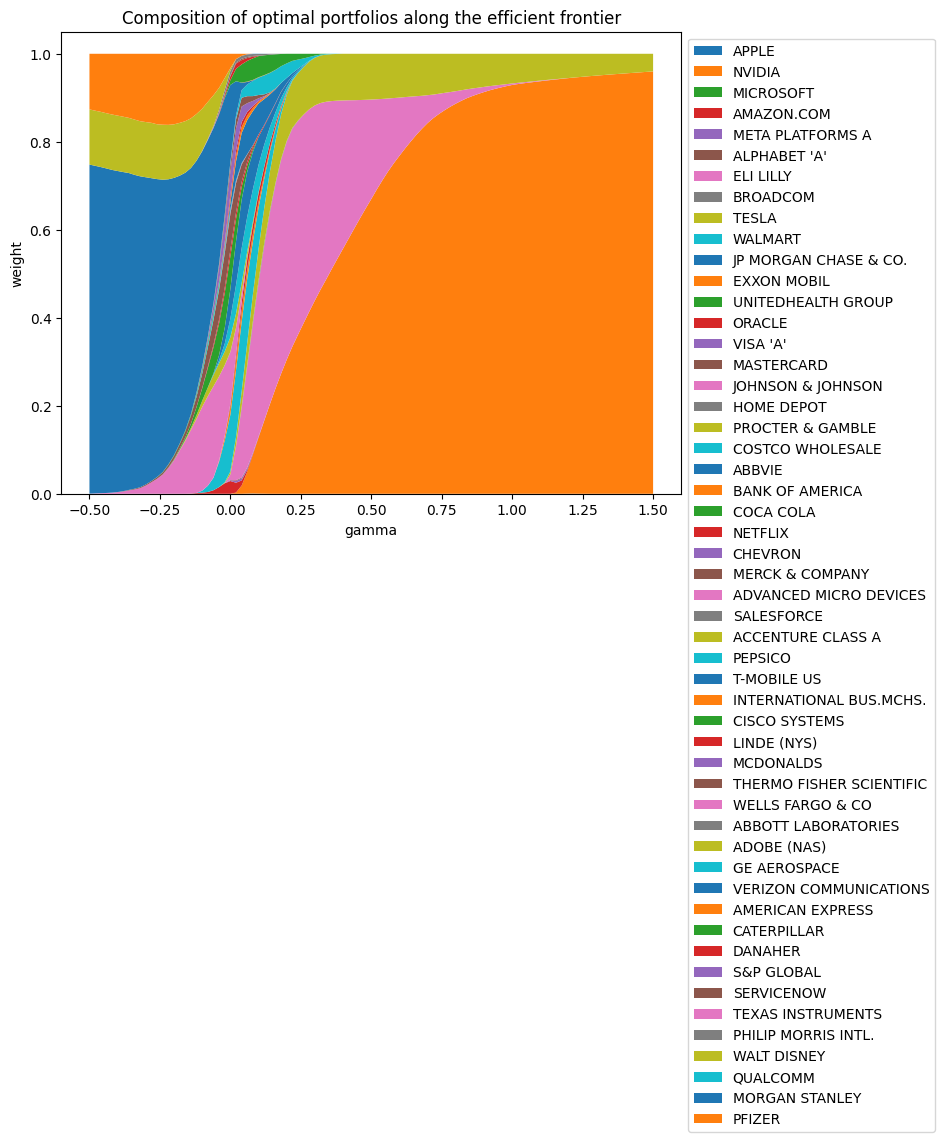

In [18]:
avg_weights = all_weights.groupby(by='gamma').mean()
avg_weights.sum(axis=1)

data_composition_map2 = pd.DataFrame(avg_weights, columns = prices.columns, index = np.linspace(-0.5,1.5,101))

fig, ax = plt.subplots(figsize=(8, 6))
ax.stackplot(data_composition_map2.index, data_composition_map2.T.values, labels=data_composition_map2.columns)
ax.set_title('Composition of optimal portfolios along the efficient frontier')
ax.set_ylabel('weight')
ax.set_xlabel('gamma')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))